In [1]:
import os.path
import pickle
import string
from collections import Counter

import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

nltk.download('stopwords')


def process_text(df):
    df['Summary'].fillna('', inplace=True)
    df['Text'].fillna('', inplace=True)
    df['Summary'] = df['Summary'].apply(stem_sent)
    df['Text'] = df['Text'].apply(stem_sent)
    return df


def stem_sent(text):
    if not text:
        return

    stemmer = SnowballStemmer('english')
    text = text.lower()

    words = word_tokenize(text)
    result = []
    for w in words:
        # remove all punctuation
        if w in string.punctuation or w in stopwords.words('english'):
            continue
        result.append(stemmer.stem(w))
    return ' '.join(result)


def calc_counter(text, vocab_counter):
    counter = Counter(text.split())
    vocab_counter += counter


def one_hot(text, vocabulary):
    vec = [0] * (len(vocabulary) + 1)
    counter = Counter(text.split())
    for k, v in counter.items():
        if k in vocabulary:
            vec[vocabulary[k]] = v
        else:
            vec[0] += v
    return vec


def convert2Id(text, id_dict):
    if text in id_dict:
        return id_dict[text]
    else:
        return 0



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\97661\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The stem will takes a looooooong time, like a whole night!

In [2]:
# Load files into DataFrames
print('loading data...')
if os.path.exists('./data/X_train_stem.csv'):
    X_train = pd.read_csv("./data/X_train_stem.csv", index_col=0)
    X_submission = pd.read_csv("./data/X_test_stem.csv", index_col=0)
    X_train[['Summary', 'Text']] = X_train[['Summary', 'Text']].astype(str)
    X_submission[['Summary', 'Text']] = X_submission[['Summary', 'Text']].astype(str)
else:
    X_train = pd.read_csv("./data/X_train.csv", index_col=0)
    X_submission = pd.read_csv("./data/X_test.csv", index_col=0)
    X_train[['Summary', 'Text']] = X_train[['Summary', 'Text']].astype(str)
    X_submission[['Summary', 'Text']] = X_submission[['Summary', 'Text']].astype(str)
    # stem word
    print('stem data')
    X_train = process_text(X_train)
    X_train.to_csv("./data/X_train_stem.csv")
    X_submission = process_text(X_submission)
    X_submission.to_csv("./data/X_test_stem.csv")

# not use stem, load the original data:
# X_train = pd.read_csv("./data/X_train.csv", index_col=0)
# X_submission = pd.read_csv("./data/X_test.csv", index_col=0)
# X_train[['Summary', 'Text']] = X_train[['Summary', 'Text']].astype(str)
# X_submission[['Summary', 'Text']] = X_submission[['Summary', 'Text']].astype(str)

loading data...


In [3]:
date = pd.to_datetime(X_train['Time'], unit='s')
X_train['Day'] = date.dt.day
X_train['Month'] = date.dt.month
X_train['Year'] = date.dt.year

date = pd.to_datetime(X_submission['Time'], unit='s')
X_submission['Day'] = date.dt.day
X_submission['Month'] = date.dt.month
X_submission['Year'] = date.dt.year

In [4]:
from sklearn import preprocessing
import numpy as np
from sklearn.compose import make_column_transformer

column_trans = make_column_transformer(
    # (preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['ProductId', 'UserId']),
    (preprocessing.MinMaxScaler(), ['Day', 'Month', 'Year']), 
    # ('passthrough', ['Day', 'Month', 'Year']), 
    ('passthrough', ['Helpfulness']),
    (TfidfVectorizer(stop_words={'english'}, min_df=10, ngram_range=(1,1)), 'Summary'),
    (TfidfVectorizer(stop_words={'english'}, min_df=10, ngram_range=(2,2)), 'Text'),
    n_jobs=-1
)

In [5]:
X_train.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,Day,Month,Year
Id,,,,,,,,,,,,
0,0005019281,ADZPIG9QOCDG5,0,0,4.0,1203984000,good version classic,charm version classic dicken 's tale henri win...,0.0,26,2,2008
1,0005019281,A35947ZP82G7JH,0,0,3.0,1388361600,good move,good emot move christma carol dicken like chri...,0.0,30,12,2013
2,0005019281,A3UORV8A9D5L2E,0,0,3.0,1388361600,winkler 's perform ok best,n't get wrong winkler wonder charact actor wou...,0.0,30,12,2013
3,0005019281,A1VKW06X1O2X7V,0,0,5.0,1202860800,'s enjoy twist classic stori,henri winkler good twist classic stori convent...,0.0,13,2,2008
4,0005019281,A3R27T4HADWFFJ,0,0,4.0,1387670400,best scroog yet,one best scroog movi henri winkler outdo cast ...,0.0,22,12,2013


In [6]:
x = X_train[:100]
column_trans.fit(x)
newdata = column_trans.transform(x)
# newdata.toarray()
newdata.shape
newdata

array([[0.83333333, 0.09090909, 0.57142857, 0.        , 0.        ,
        0.        , 0.        , 0.73409342, 0.67904849],
       [0.96666667, 1.        , 0.92857143, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.96666667, 1.        , 0.92857143, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.4       , 0.09090909, 0.57142857, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.7       , 1.        , 0.92857143, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.96666667, 1.        , 0.57142857, 1.        , 0.        ,
        0.        , 1.        , 0.73409342, 0.67904849],
       [0.46666667, 1.        , 0.64285714, 0.        , 0.61992876,
        0.57677884, 0.53199107, 0.        , 0.        ],
       [0.13333333, 1.        , 0.92857143, 0.        , 0.61992876,
        0.57677884, 0.53199107, 0.73409342, 0.67904849],


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
 
# steps = make_pipeline(column_trans, ComplementNB())
train_set = column_trans.fit_transform(X_train)

cv_results = cross_validate(ComplementNB(), train_set, X_train['Score'], cv=10, return_train_score=True, return_estimator=True)
print(cv_results['test_score'])
print(cv_results['train_score'])

[0.60730999 0.6003406  0.6073243  0.60290656 0.61446981 0.62774323
 0.63443361 0.64138158 0.65020429 0.65385358]
[0.75072966 0.75158037 0.7514937  0.75129911 0.75225636 0.75226431
 0.75248851 0.75170459 0.75098825 0.7504985 ]


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "E:\anaconda3\envs\cs506\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "E:\anaconda3\envs\cs506\lib\site-packages\joblib\externals\loky\process_executor.py", line 566, in run
    self.terminate_broken(bpe)
  File "E:\anaconda3\envs\cs506\lib\site-packages\joblib\externals\loky\process_executor.py", line 750, in terminate_broken
    self.kill_workers(reason="broken executor")
  File "E:\anaconda3\envs\cs506\lib\site-packages\joblib\externals\loky\process_executor.py", line 781, in kill_workers
    recursive_terminate(p)
  File "E:\anaconda3\envs\cs506\lib\site-packages\joblib\externals\loky\backend\utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "E:\anaconda3\envs\cs506\lib\site-packages\joblib\externals\loky\backend\utils.py", line 53, in _recursive_terminate_without_psutil
    _recursive_terminate(process.pid)
  File "E:\anaco

In [ ]:
print(len(cv_results))
print(cv_results['test_score'][cv_results['test_score'].argmax()])

test_set = column_trans.transform(X_submission)
optimal = cv_results['estimator'][cv_results['test_score'].argmax()]
X_submission['Score'] = optimal.predict(test_set)
X_submission[['Score']].to_csv('./data/submission.csv')

5
0.6538535845384357


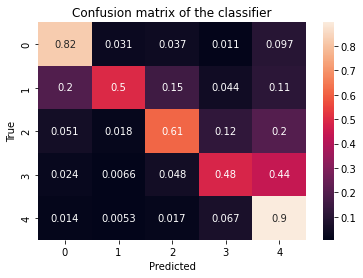

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pre = optimal.predict(train_set)

# Plot a confusion matrix
cm = confusion_matrix(X_train['Score'], pre, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()